# **Book Recommendation System — Collaborative Filtering Approach**

**Author:** Milos Saric [https://saricmilos.com/]  
**Date:** November 04, 2025 - November 18th, 2025  
**Dataset:** Kaggle — *Book Recommendation Dataset*  

---

### Required Libraries Import

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
%load_ext autoreload
%autoreload 2

from src.dataloader import load_all_csvs_from_folder
from src.preprocess_user_books_ratings import preprocess_books_ratings_users

In [3]:
# Core
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [4]:
from src.user_cf import UserBasedCF

In [5]:
from src.item_cf import (
    filter_users_items,
    train_test_split_by_user,
    CFEncoders,
    build_item_user_matrix,
    compute_item_similarity,
    get_top_k_items,
    predict_ratings,
    evaluate_predictions,
    recommend_for_user,
    recommend_similar_items
)

In [6]:
import pickle

In [7]:
dataset_folder = Path(r"C:\Users\Milos\Desktop\ESCAPE_9-5\PYTHON\GitHub_Kaggle_Projects\what-else-should-I-read\datasets")

In [8]:
datasets = load_all_csvs_from_folder(dataset_folder,low_memory=False)

In [9]:
merged_df = preprocess_books_ratings_users(
    datasets["Books"],
    datasets["Ratings"],
    datasets["Users"]
)

In [10]:
merged_df.shape

(383839, 21)

# **1. Collaborative Filtering**

For **collaborative filtering (CF)**, we only need the core **user–item interactions**: `user_id`, `isbn` or `book title encoded`, and `book_rating`.  
Other Metadata like user demographics, or book averages aren’t used in standard CF models, though they can be incorporated in **hybrid approaches**.  

CF works by learning **similarity patterns**:  
- Users who rate similar books in similar ways  
- Books that are rated similarly by similar users  

Other columns (age, country, author_avg_rating, etc.) are **side information**. They are useful for:  
- Content-based recommenders  
- Hybrid models combining CF with features  
- Analytics, fairness, or deeper insights  

But for a **pure CF matrix**, only the core user–item-rating data is needed.

### Step 1: filter active users and reasonably-rated books:
New users have no interaction history, so it’s hard to find similar users. New items have few or no ratings, making them difficult to recommend.  

Create new data frame that only consists of user-item ratings

In [11]:
cf_df = merged_df[['user_id', 'book_title', 'book_rating']].copy()

In [12]:
min_user_ratings = 10
min_book_ratings = 10

Groups the dataframe cf_df by each user_id. Count the number of ratings each user has made (how many books they rated).Groups the dataframe by book_title. Counts how many users rated each book.

In [13]:
# Compute user and book counts
user_counts = cf_df.groupby('user_id')['book_rating'].count()
book_counts = cf_df.groupby('book_title')['book_rating'].count()

In [14]:
print(cf_df['user_id'].nunique())  # total users
print(cf_df['book_title'].nunique())  # total books

print(sum(user_counts >= min_user_ratings))  # users meeting threshold
print(sum(book_counts >= min_book_ratings))  # books meeting threshold

68091
135564
6589
5712


In [15]:
cf_df_filtered = cf_df.copy()

while True:
    # Count ratings per user and per book
    user_counts = cf_df_filtered.groupby('user_id')['book_rating'].count()
    book_counts = cf_df_filtered.groupby('book_title')['user_id'].count()
    
    # Keep users and books meeting thresholds
    active_users = user_counts[user_counts >= min_user_ratings].index
    active_books = book_counts[book_counts >= min_book_ratings].index
    
    filtered = cf_df_filtered[
        cf_df_filtered['user_id'].isin(active_users) &
        cf_df_filtered['book_title'].isin(active_books)
    ]
    
    # Stop if dataframe does not change
    if len(filtered) == len(cf_df_filtered):
        break
    
    cf_df_filtered = filtered.copy()

# Final checks
print("Filtered dataframe shape:", cf_df_filtered.shape)
min_ratings_per_user = cf_df_filtered.groupby('user_id')['book_rating'].count().min()
min_ratings_per_book = cf_df_filtered.groupby('book_title')['user_id'].count().min()

print(f"Minimum number of books rated by any user: {min_ratings_per_user}")
print(f"Minimum number of ratings for any book: {min_ratings_per_book}")

Filtered dataframe shape: (56967, 3)
Minimum number of books rated by any user: 10
Minimum number of ratings for any book: 10


C:\Users\Milos\AppData\Local\Temp\ipykernel_1656\1324216637.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=freq.index.astype(int), y=freq.values, palette='pastel')


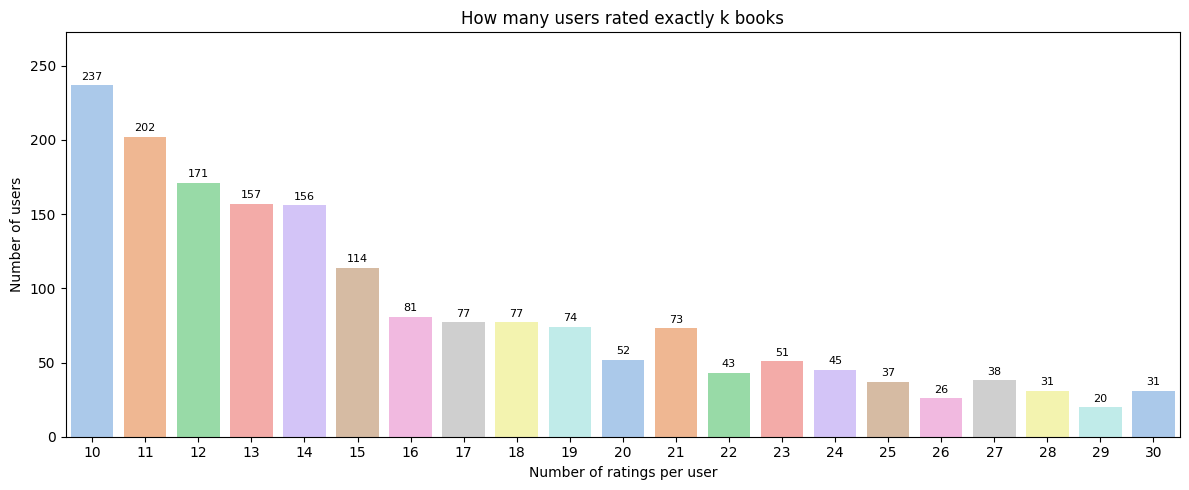

In [16]:
# Count how many ratings each user gave
user_counts = cf_df_filtered.groupby('user_id')['book_rating'].count()

# Count how many users gave exactly k ratings
freq = user_counts.value_counts().sort_index()

# Limit to a sensible range (e.g., up to 30 ratings)
max_k = 30
freq = freq.loc[freq.index <= max_k]

plt.figure(figsize=(12,5))
ax = sns.barplot(x=freq.index.astype(int), y=freq.values, palette='pastel')
plt.xlabel('Number of ratings per user')
plt.ylabel('Number of users')
plt.title('How many users rated exactly k books')

# Dynamically adjust y-axis to leave space for numbers
plt.ylim(0, freq.values.max() * 1.15)

# Annotate bars above each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,  # center of the bar
        height + freq.values.max() * 0.01,  # small offset above the bar
        f"{int(height)}",
        ha='center',
        va='bottom',
        fontsize=8
    )

plt.tight_layout()
plt.show()

In [17]:
user_counts.value_counts()

book_rating
10     237
11     202
12     171
13     157
14     156
      ... 
141      1
85       1
131      1
92       1
100      1
Name: count, Length: 115, dtype: int64

C:\Users\Milos\AppData\Local\Temp\ipykernel_1656\3243285769.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=freq_books.index.astype(int), y=freq_books.values, palette='pastel')


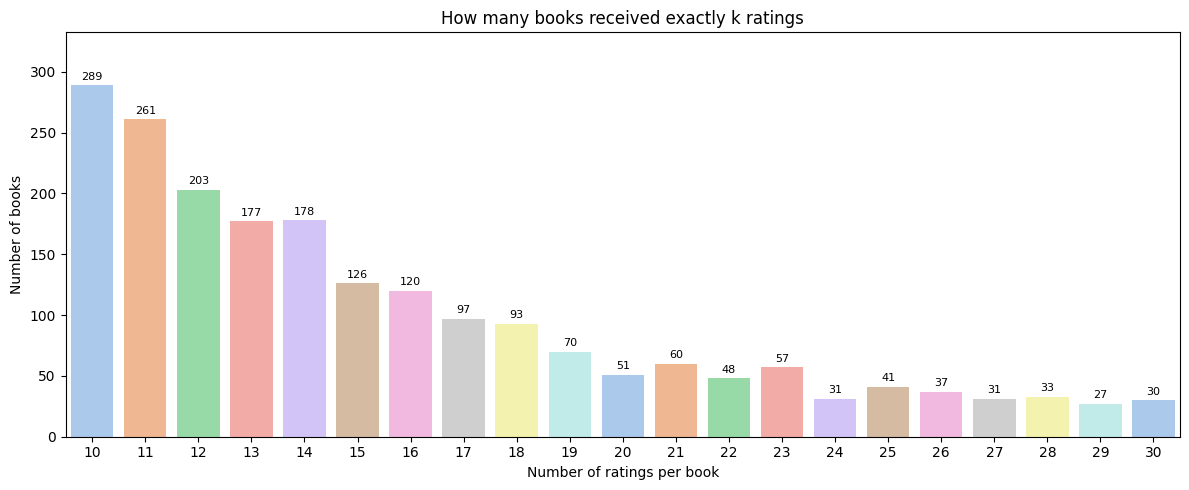

In [18]:
# Count how many ratings each book received
book_counts = cf_df_filtered.groupby('book_title')['book_rating'].count()

# Count how many books received exactly k ratings
freq_books = book_counts.value_counts().sort_index()

# Optionally limit to a sensible range (e.g., up to 30 ratings)
max_k = 30
freq_books = freq_books.loc[freq_books.index <= max_k]

plt.figure(figsize=(12,5))
ax = sns.barplot(x=freq_books.index.astype(int), y=freq_books.values, palette='pastel')
plt.xlabel('Number of ratings per book')
plt.ylabel('Number of books')
plt.title('How many books received exactly k ratings')

# Dynamically adjust y-axis to leave space for numbers
plt.ylim(0, freq_books.values.max() * 1.15)

# Annotate bars above each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,  # center of the bar
        height + freq_books.values.max() * 0.01,  # small offset above the bar
        f"{int(height)}",
        ha='center',
        va='bottom',
        fontsize=8
    )

plt.tight_layout()
plt.show()

In [19]:
book_counts.value_counts()

book_rating
10     289
11     261
12     203
14     178
13     177
      ... 
128      1
178      1
94       1
98       1
124      1
Name: count, Length: 107, dtype: int64

### Step 2: Per User Train/Test Split

To evaluate the model realistically, we create a **train/test split for each user**. Each user should have some ratings in the train set (so the model can learn their preferences) and some ratings in the test set (so we can evaluate the recommendations).  

It’s important to make this split **reproducible** by setting a random seed, ensuring consistent results across runs.


1. **Setup**:  
   - `test_frac = 0.2` sets 20% of each user’s ratings for testing.  
   - A fixed random seed (`random_seed = 42`) ensures reproducibility.

2. **Per-user splitting**:  
   - The dataframe is grouped by `user_id`.  
   - For each user, their rating indices are shuffled randomly.  
   - The first `n_test` ratings go to the test set, the rest to the train set.  
   - If a user has only one rating in train or test, it ensures they appear in **both sets** by moving one rating to train if needed.

3. **Build train/test sets**:  
   - `train_df` contains all training ratings.  
   - `test_df` contains all test ratings.  
   - Resetting the index keeps the data clean.

4. **Outcome**:  
   - Every user is present in both train and test.  
   - Train and test rows can now be used to **train the CF model** and **evaluate recommendations** reliably.

The final print statements confirm the number of rows and unique users in each split.

In [20]:
# Parameters
test_frac = 0.2
random_seed = 42
rng = np.random.RandomState(random_seed)

train_idxs = []
test_idxs = []

# group by user and split each user’s ratings
for user, group in cf_df_filtered.groupby('user_id'):
    idxs = group.index.tolist()
    rng.shuffle(idxs)
    
    n_test = max(1, int(round(test_frac * len(idxs))))
    test_for_user = idxs[:n_test]
    train_for_user = idxs[n_test:]
    
    # ensure user appears in train too
    if len(train_for_user) == 0 and len(test_for_user) > 1:
        train_for_user.append(test_for_user.pop())
    
    train_idxs.extend(train_for_user)
    test_idxs.extend(test_for_user)

# Create splits
train_df = cf_df_filtered.loc[train_idxs].reset_index(drop=True)
test_df = cf_df_filtered.loc[test_idxs].reset_index(drop=True)

print("Train rows:", len(train_df))
print("Test rows :", len(test_df))
print("Unique users in train:", train_df['user_id'].nunique())
print("Unique users in test :", test_df['user_id'].nunique())

Train rows: 45592
Test rows : 11375
Unique users in train: 2272
Unique users in test : 2272


In [21]:
cf_df_filtered['user_id'].nunique()

2272

In [22]:
cf_df_filtered['book_title'].nunique()

2508

In [23]:
# Users
train_users = set(train_df['user_id'])
test_users  = set(test_df['user_id'])
unseen_users = test_users - train_users
print(f"Unseen users in test: {len(unseen_users)}")

# Items
train_items = set(train_df['book_title'])
test_items  = set(test_df['book_title'])
unseen_items = test_items - train_items
print(f"Unseen items in test: {len(unseen_items)}")

Unseen users in test: 0
Unseen items in test: 0


In [24]:
# Create label encoders
user_encoder = preprocessing.LabelEncoder()
item_encoder = preprocessing.LabelEncoder()

# Fit on train set users/items
train_df['user_idx'] = user_encoder.fit_transform(train_df['user_id'])
train_df['book_idx'] = item_encoder.fit_transform(train_df['book_title'])

# Apply same mapping to test set
test_df['user_idx'] = user_encoder.transform(test_df['user_id'])
test_df['book_idx'] = item_encoder.transform(test_df['book_title'])

print("Unique users encoded:", train_df['user_idx'].nunique())
print("Unique books encoded:", train_df['book_idx'].nunique())

Unique users encoded: 2272
Unique books encoded: 2508


In [25]:
train_df.head()

,user_id,book_title,book_rating,user_idx,book_idx
0,243,The Patient,8,0,2092
1,243,Manhattan Hunt Club,6,0,1088
2,243,The General's Daughter,9,0,1906
3,243,A Map of the World,7,0,55
4,243,Unnatural Exposure,9,0,2378


In [26]:
test_df.head()

,user_id,book_title,book_rating,user_idx,book_idx
0,243,The Bean Trees,10,0,1717
1,243,The God of Small Things,7,0,1921
2,243,"River, Cross My Heart",7,0,1426
3,254,"The Golden Compass (His Dark Materials, Book 1)",8,1,1923
4,254,Harry Potter and the Prisoner of Azkaban (Book 3),9,1,786


# **1.1. User Based CF**

### Step 3: Build user-item MATRIX

Construct a sparse matrix using csr_matrix. Each entry in the matrix represents a rating a user gave to a book.

In [27]:
# Dimensions
num_users = train_df['user_idx'].nunique()
num_items = train_df['book_idx'].nunique()

In [28]:
print(f"Matrix dimensions: {num_users} users x {num_items} books")

Matrix dimensions: 2272 users x 2508 books


In [29]:
# Build sparse matrix
train_matrix = csr_matrix(
    (train_df['book_rating'], 
     (train_df['user_idx'], train_df['book_idx'])),
    shape=(num_users, num_items)
)

In [30]:
# Total possible entries
total_entries = train_matrix.shape[0] * train_matrix.shape[1]

# Number of non-zero entries (actual ratings)
nonzero_entries = train_matrix.nnz

# Zero entries
zero_entries = total_entries - nonzero_entries

print("Total entries       :", total_entries)
print("Non-zero entries    :", nonzero_entries)
print("Zero entries        :", zero_entries)

# Optional: percentage
print("Sparsity (% zeros)  :", zero_entries / total_entries * 100)
print("Density (% non-zero):", nonzero_entries / total_entries * 100)

Total entries       : 5698176
Non-zero entries    : 45230
Zero entries        : 5652946
Sparsity (% zeros)  : 99.20623722398186
Density (% non-zero): 0.7937627760181504


We can calculate how sparse the user–item matrix is and shows a small example of it for visualisation:

In [31]:
# Show a small dense sample (for inspection only)
train_dense_sample = train_df.pivot_table(
    index='user_idx', columns='book_idx', values='book_rating'
).fillna(0)
train_dense_sample.head()

book_idx,0,1,2,3,4,5,6,7,8,9,...,2498,2499,2500,2501,2502,2503,2504,2505,2506,2507
user_idx,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Step 4: Compute User-User Similarity Using Cosine Similarity (Top-K Neighbors)

In collaborative filtering, each user can be represented as a **vector of their ratings**.  

- The **length of a user vector** is the magnitude of their ratings.  
  - A user who gives many high ratings has a longer vector.  
  - A user who gives few or low ratings has a shorter vector.  

- **Cosine similarity** ignores the vector length and focuses on the **angle between vectors**:  
  - Measures how similar the **pattern of ratings** is between users.  
  - Users with similar preferences across books are considered similar, even if one tends to rate higher or lower overall.  

Using **top-K neighbors**, we focus only on the most similar users when making recommendations.

In [32]:
user_sim_matrix = cosine_similarity(train_matrix)
np.fill_diagonal(user_sim_matrix, 0)  # remove self-similarity

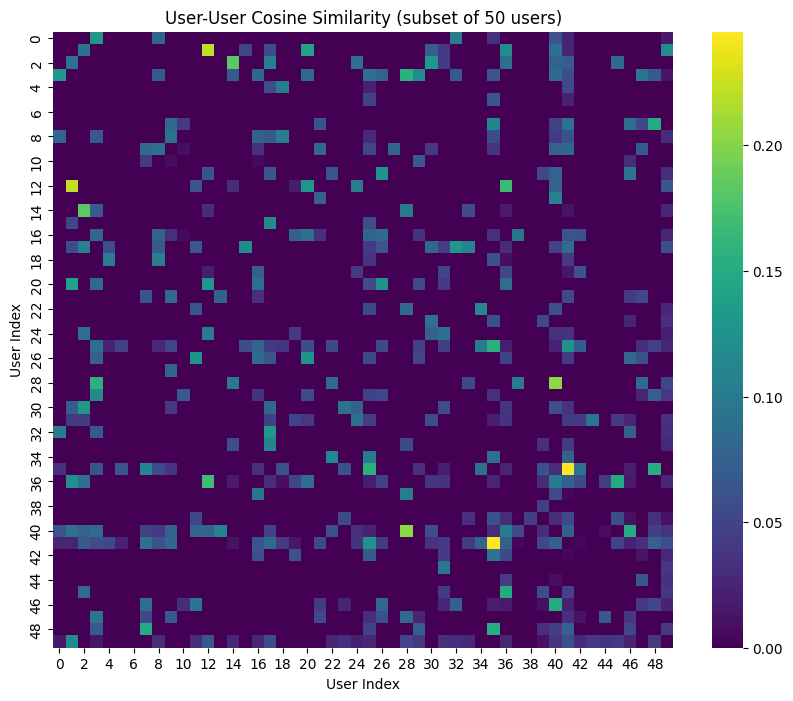

In [33]:
# Take a small subset to visualize (e.g., first 50 users)
subset = user_sim_matrix[:50, :50]

plt.figure(figsize=(10, 8))
sns.heatmap(subset, cmap='viridis')
plt.title("User-User Cosine Similarity (subset of 50 users)")
plt.xlabel("User Index")
plt.ylabel("User Index")
plt.show()

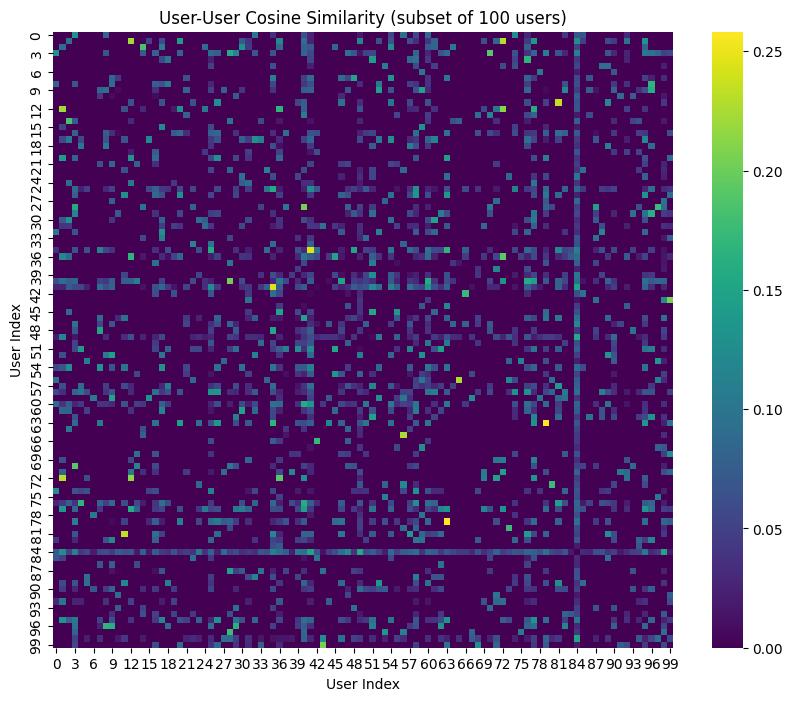

In [34]:
# Take a small subset to visualize (e.g., first 50 users)
subset = user_sim_matrix[:100, :100]

plt.figure(figsize=(10, 8))
sns.heatmap(subset, cmap='viridis')
plt.title("User-User Cosine Similarity (subset of 100 users)")
plt.xlabel("User Index")
plt.ylabel("User Index")
plt.show()

### Step 5: Choose K Nearest Neighbors

For each user, select the **top-K most similar users** from the user-user similarity matrix. These neighbors are used to generate recommendations based on what similar users have rated.

In [35]:
k = 10
top_k_users = np.argsort(-user_sim_matrix, axis=1)[:, :k]

In [36]:
top_k_users.shape

(2272, 10)

### **Step 6.Predict Ratings**  
   - For each user-item pair, calculate the predicted rating as a weighted average of the ratings from the top-k similar users.  
   - The weights are the similarity scores between the target user and each neighbor.

3. **Normalization**  
   - Normalize by the sum of similarity scores to ensure the predicted ratings are scaled correctly.  
   - If none of the neighbors rated the item, use a fallback such as the user's average rating or the global average.

4. **Build Full Prediction Matrix**  
   - Repeat this process for all users and all items.  
   - Each entry in the matrix represents the estimated rating a user would give to a particular item.

In [37]:
# Compute user means
user_means = np.array(train_matrix.mean(axis=1)).flatten()  # shape: (num_users,)

# Initialize prediction matrix
pred_matrix = np.zeros((num_users, num_items))

# Loop over each user
for u in range(num_users):
    # Top-k similar users
    neighbors = top_k_users[u]
    sim_scores = user_sim_matrix[u, neighbors]  # similarity values
    
    # Neighbor ratings
    neighbor_ratings = train_matrix[neighbors, :].toarray()  # shape (k, num_items)
    
    # Neighbor means
    neighbor_means = user_means[neighbors][:, np.newaxis]  # shape (k, 1)
    
    # Mean-centered ratings
    mean_centered = neighbor_ratings - neighbor_means  # r_vi - bar_r_v
    
    # Weighted sum
    weighted_sum = sim_scores @ mean_centered  # numerator
    sim_sum = np.sum(np.abs(sim_scores))       # denominator
    
    # Add target user mean
    pred_matrix[u, :] = user_means[u] + (weighted_sum / sim_sum if sim_sum != 0 else 0)

# Optional: fill NaNs for safety
pred_matrix = np.nan_to_num(pred_matrix)

In [38]:
user_means[3]

np.float64(0.0853269537480064)

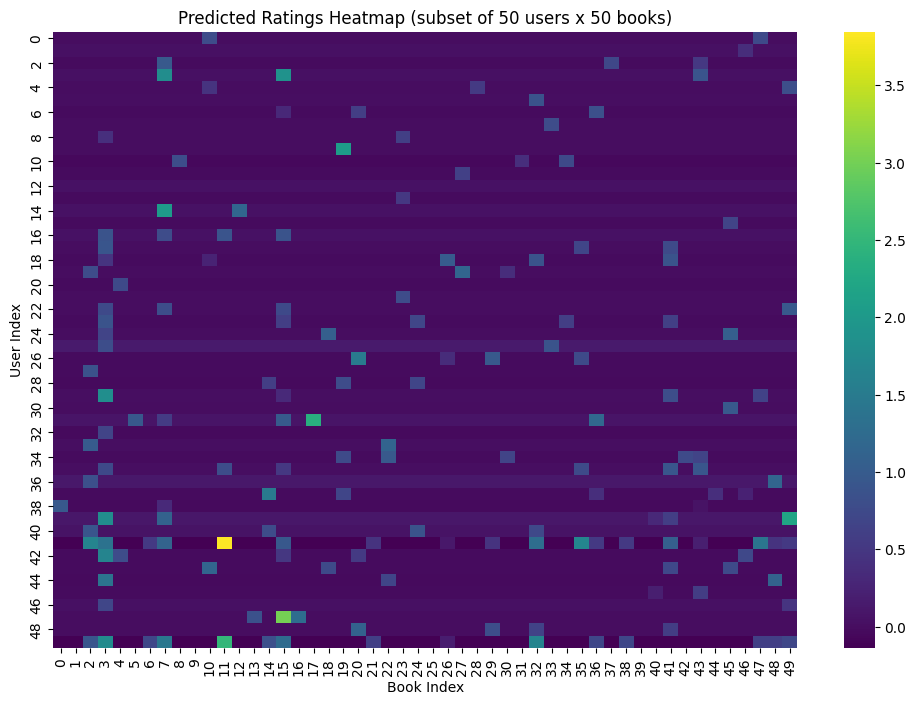

In [39]:
# Take a subset for visualization (e.g., first 50 users and 50 books)
subset = pred_matrix[:50, :50]

plt.figure(figsize=(12, 8))
sns.heatmap(subset, cmap='viridis')
plt.title("Predicted Ratings Heatmap (subset of 50 users x 50 books)")
plt.xlabel("Book Index")
plt.ylabel("User Index")
plt.show()

 **Step 7:Recommendation and Evaluation**  
   - Recommend items to users by selecting those with the highest predicted ratings.  
   - Evaluate the model by comparing predicted ratings to actual ratings in a test set.

In [40]:
def recommend_books_by_user(user_id, top_k=10):
    """
    Recommend books for a user based on user-user similarity.
    Returns the top_k books that similar users liked.
    """
    # Encode the user
    user_idx = user_encoder.transform([user_id])[0]

    # Get similarity scores for this user
    sims = user_sim_matrix[user_idx]

    # Find top-k similar users (excluding the user themselves)
    top_k_idx = np.argsort(-sims)[:top_k+1]
    top_k_idx = [i for i in top_k_idx if i != user_idx][:top_k]

    # Compute average ratings from similar users for each book
    # Use the trained rating matrix (train_matrix)
    user_ratings = train_matrix[top_k_idx].toarray().mean(axis=0)

    # Get top books not yet rated by this user
    already_rated = train_matrix[user_idx].toarray().flatten() > 0
    user_ratings[already_rated] = -np.inf  # exclude already rated

    top_books_idx = np.argsort(-user_ratings)[:top_k]

    # Convert back to book titles
    recommended_books = item_encoder.inverse_transform(top_books_idx)

    return recommended_books

In [41]:
# Example usage
recommended = recommend_books_by_user(243, top_k=10)
print(recommended)

["Drowning Ruth (Oprah's Book Club)" 'Little Altars Everywhere: A Novel'
 'River, Cross My Heart' 'Empire Falls' 'The Rapture of Canaan'
 'Midwives: A Novel' 'Fall On Your Knees (Oprah #45)' 'Jewel' 'The Reader'
 'We Were the Mulvaneys']


In [42]:
def recommend_from_pred_matrix(user_id, top_k=10):
    user_idx = user_encoder.transform([user_id])[0]

    # Get predicted ratings for this user from pred_matrix
    preds = pred_matrix[user_idx].copy()   # 1D array length num_items

    # Mask out already-rated items
    already_rated = train_matrix[user_idx].toarray().flatten() > 0
    preds[already_rated] = -np.inf

    top_books_idx = np.argsort(-preds)[:top_k]
    recommended_books = item_encoder.inverse_transform(top_books_idx)
    return recommended_books

In [43]:
recommended_pred_matrix = recommend_from_pred_matrix(243, top_k=10)
print(recommended)

["Drowning Ruth (Oprah's Book Club)" 'Little Altars Everywhere: A Novel'
 'River, Cross My Heart' 'Empire Falls' 'The Rapture of Canaan'
 'Midwives: A Novel' 'Fall On Your Knees (Oprah #45)' 'Jewel' 'The Reader'
 'We Were the Mulvaneys']


### Scenario if the User adds a new rating

In [44]:
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def add_user_rating(train_df, train_matrix, user_encoder, item_encoder,
                    user_id, book_title, rating):
    # 1) ensure user/item in encoders (see section below on encoders)
    user_idx = user_encoder.transform([user_id])[0]
    book_idx = item_encoder.transform([book_title])[0]

    # 2) update train_df
    train_df.loc[len(train_df)] = {
        'user_id': user_id, 'book_title': book_title, 'book_rating': rating,
        'user_idx': user_idx, 'book_idx': book_idx
    }

    # 3) update sparse matrix (convert to LIL for assignment)
    mat = train_matrix.tolil()
    mat[user_idx, book_idx] = rating
    train_matrix = mat.tocsr()

    # 4) update user mean
    user_row = train_matrix[user_idx, :].toarray().flatten()
    user_mean = user_row[user_row > 0].mean() if (user_row > 0).any() else 0.0
    user_means[user_idx] = user_mean   # user_means should be a mutable np.array

    # 5) recompute similarity row for this user only (cosine between user vector and all users)
    #    treat rows as vectors
    sims = cosine_similarity(train_matrix[user_idx], train_matrix).flatten()
    sims[user_idx] = 0.0   # zero-out self-similarity
    user_sim_matrix[user_idx] = sims
    user_sim_matrix[:, user_idx] = sims  # if you want symmetric (optional)

    # 6) recompute top-k neighbors for this user
    top_k_for_user = np.argsort(-sims)[:k]   # reuse global k

    # return updated structures
    return train_df, train_matrix, user_means, user_sim_matrix, top_k_for_user

# Evaluating the Recommendation System

The numbers here are not flattering. Precision and recall measure how well the system recommends books users actually like, while MAE, MSE, and RMSE measure how far off the predicted ratings are from the real ones.

Looking at the top-k metrics, Precision@5 is only 0.0542. That means out of the five books the system thinks a user will like most, **on average, only about one in twenty is actually relevant**. Even increasing the recommendations to 20 only raises recall to 0.1116, meaning the system captures barely 11% of items the user actually rated. Precision keeps dropping as k increases, showing that recommending more items mostly adds irrelevant books. This is painfully low, though not surprising given how sparse book rating datasets are.

The rating prediction errors are equally harsh. MAE of 7.3627 and RMSE of 7.6219 indicate that, on average, the predicted rating is off by more than 7 points—absolutely massive if the scale is, for example, 1–10. MSE of 58.0931 highlights that some predictions are catastrophically wrong. These numbers tell us that the model is essentially guessing in most cases. While it might pick up very rough trends, it is **terrible at predicting individual ratings** and fails to produce meaningful recommendations in practice.

In short: this model works just enough to generate numbers, but it’s nowhere near useful for real users. Expect mostly garbage recommendations if deployed as-is.

In [45]:
# True and predicted ratings for the test set
users = test_df['user_idx'].to_numpy()
items = test_df['book_idx'].to_numpy()
y_true = test_df['book_rating'].to_numpy()
y_pred = pred_matrix[users, items]

# Metrics
mae  = mean_absolute_error(y_true, y_pred)
mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f"MAE  = {mae:.4f}")
print(f"MSE  = {mse:.4f}")
print(f"RMSE = {rmse:.4f}")

MAE  = 7.3627
MSE  = 58.0931
RMSE = 7.6219


In [46]:
def precision_recall_at_n(train_df, test_df, pred_matrix, N=10, threshold=4.0):
    """
    Computes Precision@N and Recall@N for all users.
    threshold: rating threshold above which items are considered 'relevant'
    """
    # Build user → set of items in train/test
    train_items = train_df.groupby('user_idx')['book_idx'].apply(set).to_dict()
    test_items  = (
        test_df[test_df['book_rating'] >= threshold]
        .groupby('user_idx')['book_idx']
        .apply(set)
        .to_dict()
    )
    
    precisions, recalls = [], []
    
    for user, true_items in test_items.items():
        if len(true_items) == 0:
            continue
        
        # Predicted scores for this user
        scores = pred_matrix[user].copy()
        # Exclude training items
        scores[list(train_items.get(user, []))] = -np.inf
        
        # Top-N predicted items
        top_n_items = np.argsort(-scores)[:N]
        
        # Count overlap
        hits = len(set(top_n_items) & true_items)
        precisions.append(hits / N)
        recalls.append(hits / len(true_items))
    
    # Average over all users
    precision_at_n = np.mean(precisions) if precisions else 0.0
    recall_at_n    = np.mean(recalls) if recalls else 0.0
    
    return precision_at_n, recall_at_n

In [47]:
for N in [5, 10, 20]:
    p, r = precision_recall_at_n(train_df, test_df, pred_matrix, N=N, threshold=4.0)
    print(f"Precision@{N}: {p:.4f} | Recall@{N}: {r:.4f}")

Precision@5: 0.0542 | Recall@5: 0.0632
Precision@10: 0.0383 | Recall@10: 0.0848
Precision@20: 0.0260 | Recall@20: 0.1116


**1.1. Module Usage**

In [48]:
ubcf = UserBasedCF(
    min_user_ratings=10,
    min_book_ratings=10,
    k_neighbors=10,
    random_seed=42
)


In [49]:
filtered_df = ubcf.filter_dataframe(merged_df)


Filtered dataframe shape: (56967, 3)


In [50]:
ubcf.train_test_split(filtered_df, test_frac=0.2)


In [51]:
train_matrix = ubcf.build_train_matrix()


In [52]:
ubcf.compute_user_similarity()


In [53]:
ubcf.predict_ratings()


In [54]:
user_id = 243
recommendations = ubcf.recommend_books_by_user(user_id=user_id, top_k=10)
print(f"Top 10 recommendations for user {user_id}:\n", recommendations)


Top 10 recommendations for user 243:
 ["Drowning Ruth (Oprah's Book Club)" 'Little Altars Everywhere: A Novel'
 'River, Cross My Heart' 'Empire Falls' 'The Rapture of Canaan'
 'Midwives: A Novel' 'Fall On Your Knees (Oprah #45)' 'Jewel' 'The Reader'
 'We Were the Mulvaneys']


In [55]:
metrics = ubcf.evaluate_rmse_mae()
print("Evaluation metrics:", metrics)
# Example output: {'MAE': 0.92, 'MSE': 1.41, 'RMSE': 1.19}


Evaluation metrics: {'MAE': 7.362705493976705, 'MSE': 58.09312647976792, 'RMSE': np.float64(7.62188470653866)}


In [56]:
precision, recall = ubcf.precision_recall_at_n(N=10, threshold=4.0)
print(f"Precision@10: {precision:.4f}, Recall@10: {recall:.4f}")


Precision@10: 0.0383, Recall@10: 0.0848


# **1.2. Item Based CF**

### Step 3: Build item-user MATRIX

In [57]:
# Dimensions
num_users = train_df['user_idx'].nunique()
num_items = train_df['book_idx'].nunique()

In [58]:
item_user_train_matrix = csr_matrix(
    (train_df['book_rating'], 
     (train_df['book_idx'], train_df['user_idx'])),
    shape=(num_items, num_users)
)

We can calculate how sparse the item-user matrix is and shows a small example of it for visualisation:

In [59]:
# Density = proportion of filled ratings
density = item_user_train_matrix.count_nonzero() / (num_users * num_items)
print(f"Matrix density: {density:.4f}")

# Show a small dense sample (for inspection only)
train_dense_sample = train_df.pivot_table(
    index='book_idx', columns='user_idx', values='book_rating'
).fillna(0)
train_dense_sample.head()

Matrix density: 0.0079


user_idx,0,1,2,3,4,5,6,7,8,9,...,2262,2263,2264,2265,2266,2267,2268,2269,2270,2271
book_idx,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Step 4: Compute Item-Item Similarity Using Cosine Similarity (Top-K Neighbors)

In [60]:
item_sim_matrix = cosine_similarity(item_user_train_matrix)
np.fill_diagonal(item_sim_matrix, 0)  # remove self-similarity

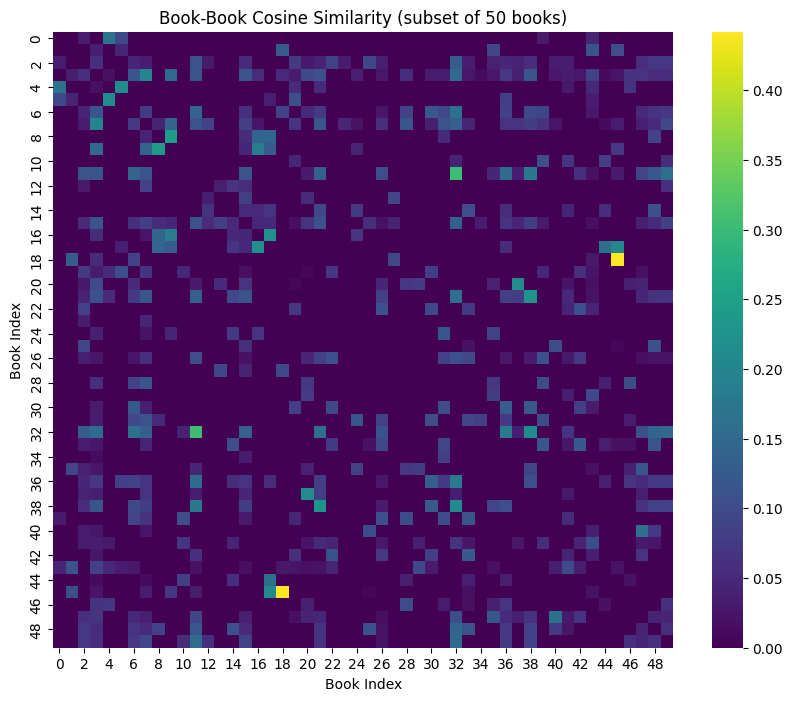

In [61]:
# Take a small subset to visualize (e.g., first 50 books)
subset = item_sim_matrix[:50, :50]

plt.figure(figsize=(10, 8))
sns.heatmap(subset, cmap='viridis')
plt.title("Book-Book Cosine Similarity (subset of 50 books)")
plt.xlabel("Book Index")
plt.ylabel("Book Index")
plt.show()

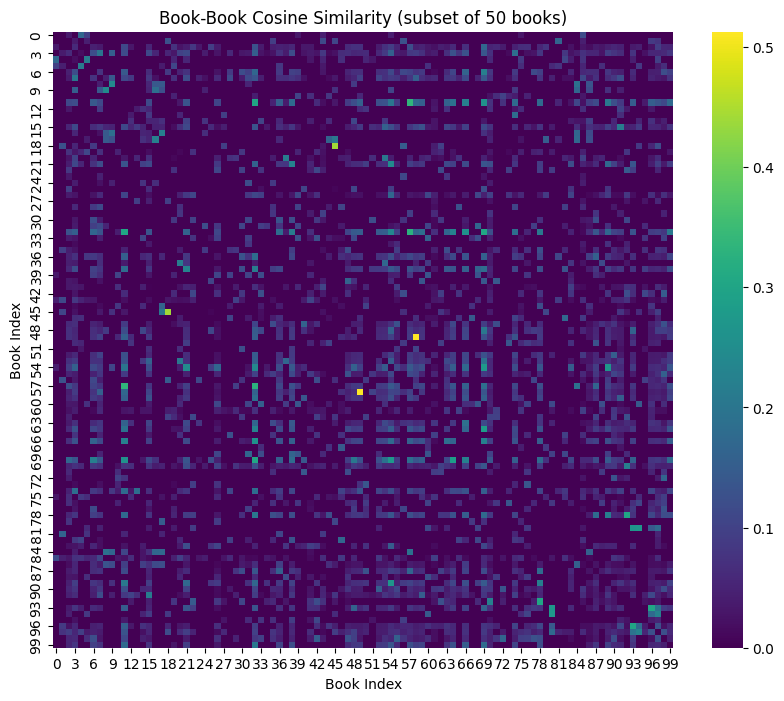

In [62]:
# Take a small subset to visualize (e.g., first 100 Books)
subset = item_sim_matrix[:100, :100]

plt.figure(figsize=(10, 8))
sns.heatmap(subset, cmap='viridis')
plt.title("Book-Book Cosine Similarity (subset of 50 books)")
plt.xlabel("Book Index")
plt.ylabel("Book Index")
plt.show()

### Step 5: Choose K Nearest Neighbors

In [63]:
k = 10
top_k_items = np.argsort(-item_sim_matrix, axis=1)[:, :k]

**Step 6.Predict Ratings**  

When we want predicted ratings for a specific user.

In [64]:
num_items, num_users = item_user_train_matrix.shape
item_means = np.array(item_user_train_matrix.mean(axis=1)).flatten()
item_pred_matrix = np.zeros((num_users, num_items))

for i in range(num_items):
    neighbors = top_k_items[i]
    sim_scores = item_sim_matrix[i, neighbors]  # (k,)
    
    # Convert sparse matrix slice to dense
    neighbor_ratings_dense = item_user_train_matrix[neighbors, :].toarray()  # (k, num_users)
    
    neighbor_means = item_means[neighbors][:, np.newaxis]  # (k,1)
    mean_centered = neighbor_ratings_dense - neighbor_means  # (k,num_users)
    
    # Mask for where users actually rated neighbor items
    mask = neighbor_ratings_dense != 0
    
    # Weighted sum
    weighted_sum = (sim_scores[:, np.newaxis] * mean_centered) * mask
    sim_sum_per_user = np.sum(np.abs(sim_scores[:, np.newaxis] * mask), axis=0)
    
    # Avoid division by zero
    pred = np.where(sim_sum_per_user != 0, weighted_sum.sum(axis=0) / sim_sum_per_user, 0)
    item_pred_matrix[:, i] = item_means[i] + pred

# Ensure no NaNs
item_pred_matrix = np.nan_to_num(item_pred_matrix)


C:\Users\Milos\AppData\Local\Temp\ipykernel_1656\929455922.py:23: RuntimeWarning: invalid value encountered in divide
  pred = np.where(sim_sum_per_user != 0, weighted_sum.sum(axis=0) / sim_sum_per_user, 0)


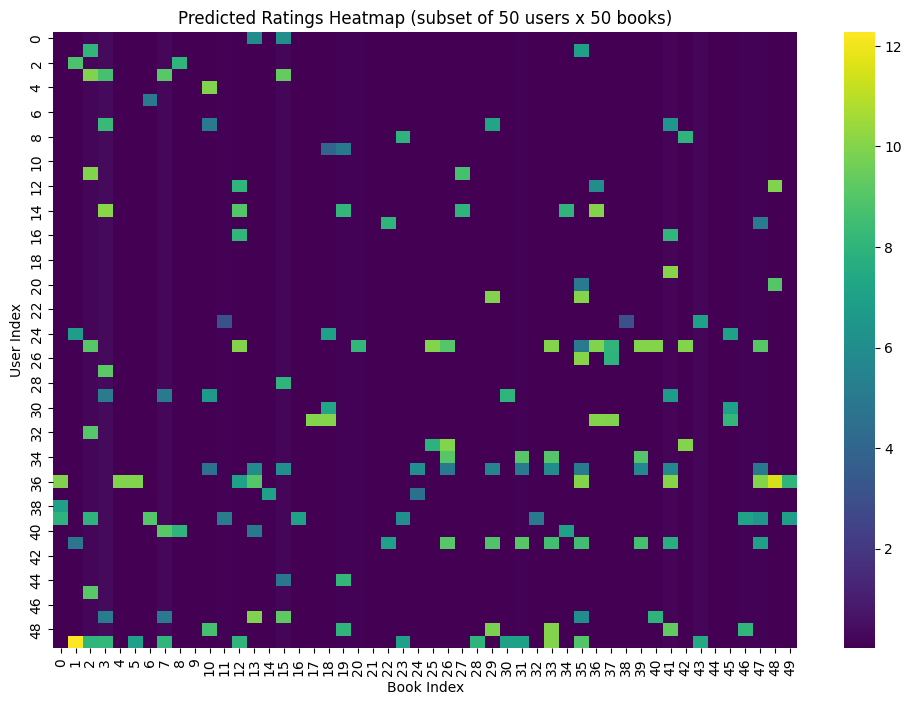

In [65]:
# Take a subset for visualization (e.g., first 50 users and 50 books)
subset = item_pred_matrix[:50, :50]

plt.figure(figsize=(12, 8))
sns.heatmap(subset, cmap='viridis')
plt.title("Predicted Ratings Heatmap (subset of 50 users x 50 books)")
plt.xlabel("Book Index")
plt.ylabel("User Index")
plt.show()

 **Step: Recommendation and Evaluation**  

In [66]:
def recommend_books_for_user_item_based(user_id, user_encoder, item_encoder, item_pred_matrix, n=10):
    """
    Recommend top-n books for a given user using the item-based prediction matrix.
    """
    # Encode the user (ensure it's known)
    user_idx = user_encoder.transform([user_id])[0]

    # Get the user’s predicted ratings
    user_preds = item_pred_matrix[user_idx]

    # Get top-N item indices
    top_items_idx = np.argsort(-user_preds)[:n]

    # Decode item titles
    recommended_books = item_encoder.inverse_transform(top_items_idx)

    # Get corresponding predicted scores
    predicted_scores = user_preds[top_items_idx]

    # Return both titles and scores
    return list(zip(recommended_books, predicted_scores))


In [67]:
# Example: recommend 10 books for user_id = 243
user_id = 243
recommendations = recommend_books_for_user_item_based(
    user_id=user_id,
    user_encoder=user_encoder,
    item_encoder=item_encoder,
    item_pred_matrix=item_pred_matrix,
    n=10
)

In [68]:
print(f"Top 10 recommendations for user {user_id}:\n")
for book, score in recommendations:
    print(f"{book} — predicted rating: {score:.2f}")

Top 10 recommendations for user 243:

The Cove — predicted rating: 9.98
On the Occasion of My Last Afternoon — predicted rating: 9.96
The Lovely Bones: A Novel — predicted rating: 9.42
Black Notice — predicted rating: 9.01
Cradle and All — predicted rating: 9.01
Point of Origin — predicted rating: 9.00
Cruel &amp; Unusual (Kay Scarpetta Mysteries (Paperback)) — predicted rating: 8.99
From Potter's Field — predicted rating: 8.99
The Last Precinct — predicted rating: 8.98
The Body Farm — predicted rating: 8.97


In [69]:
def recommend_books_by_book(book_title, top_k=10):
    # Encode book
    book_idx = item_encoder.transform([book_title])[0]
    
    # Get similarity scores for this book
    sims = item_sim_matrix[book_idx]
    
    # Top-k similar books (excluding the book itself)
    top_k_idx = np.argsort(-sims)[:top_k+1]
    top_k_idx = [i for i in top_k_idx if i != book_idx][:top_k]
    
    # Convert indices back to book titles
    recommended_books = item_encoder.inverse_transform(top_k_idx)
    
    return recommended_books

In [70]:
recommend_books_by_book("The Da Vinci Code")

array(['Angels &amp; Demons', 'Middlesex: A Novel',
       'The Lovely Bones: A Novel', 'Touching Evil',
       'The Secret Life of Bees', 'The Conspiracy Club', 'Street Dreams',
       'Digital Fortress : A Thriller', 'Jennifer Government : A Novel',
       'The Dante Club : A Novel'], dtype=object)

# Evaluating the Item-Based Recommendation System


Looking at the top-N metrics, Precision@5 is only 0.0742, which means that out of the five books recommended to a user, **less than one book on average is actually relevant**. Even when we increase N to 20, the system captures only about 16% of the relevant items in Recall@20. Precision drops as more items are recommended, showing that most of what the system suggests is irrelevant. This slight improvement over the user-based method shows that item-based CF captures some patterns in item similarity, but it is still extremely weak for meaningful recommendations. Sparse user ratings and limited overlap between items are major limiting factors.

The rating prediction errors remain harsh. MAE of 7.1474 and RMSE of 7.4423 indicate that the predicted ratings are still **off by more than 7 points on average**, which is massive if your rating scale is, for example, 1–10. MSE of 55.3873 highlights that some predictions are catastrophically wrong. These numbers suggest that while the item-based method is slightly better at ranking relevant items than user-based CF, it still **fails to predict actual ratings accurately** and would provide mostly useless recommendations if deployed.

In short: item-based CF is a small step forward, but it is still far from usable in practice. Most recommendations are irrelevant, and the predicted ratings are wildly inaccurate.

In [71]:
# Extract user and item indices from the test set
users = test_df['user_idx'].to_numpy()
items = test_df['book_idx'].to_numpy()

# True ratings
y_true = test_df['book_rating'].to_numpy()

# Predicted ratings from your item-based CF matrix
y_pred = item_pred_matrix[users, items]

# Compute metrics
mae  = mean_absolute_error(y_true, y_pred)
mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f"MAE  = {mae:.4f}")
print(f"MSE  = {mse:.4f}")
print(f"RMSE = {rmse:.4f}")

MAE  = 5.2947
MSE  = 40.9818
RMSE = 6.4017


In [72]:
def precision_recall_at_n_book_to_book(test_df, item_sim_matrix, item_encoder, input_books, N=10, threshold=4.0):
    """
    Computes Precision@N and Recall@N for book-to-book recommendations.
    
    test_df: DataFrame with columns ['user_idx', 'book_idx', 'book_rating']
    item_sim_matrix: item-item similarity matrix
    item_encoder: fitted LabelEncoder for books
    input_books: list of book titles to test
    N: top-N recommendations
    threshold: rating threshold to consider an item relevant
    """
    precisions, recalls = [], []
    
    for book in input_books:
        # Encode input book
        book_idx = item_encoder.transform([book])[0]
        
        # Get similarity scores for this book
        sims = item_sim_matrix[book_idx]
        
        # Top-N recommended items excluding the book itself
        top_n_idx = np.argsort(-sims)[:N+1]
        top_n_idx = [i for i in top_n_idx if i != book_idx][:N]
        
        # Find users who rated this book above threshold in the test set
        relevant_users = set(test_df[(test_df['book_idx'] == book_idx) & 
                                     (test_df['book_rating'] >= threshold)]['user_idx'])
        
        if not relevant_users:
            continue
        
        # For each recommended book, count how many of these relevant users also rated it above threshold
        hits = 0
        for rec_idx in top_n_idx:
            rec_users = set(test_df[(test_df['book_idx'] == rec_idx) & 
                                    (test_df['book_rating'] >= threshold)]['user_idx'])
            hits += len(relevant_users & rec_users)
        
        # Precision = hits / (N * len(relevant_users)) ?
        precisions.append(hits / (N * len(relevant_users)))
        recalls.append(hits / len(relevant_users))
    
    # Average over all input books
    precision_at_n = np.mean(precisions) if precisions else 0.0
    recall_at_n    = np.mean(recalls) if recalls else 0.0
    
    return precision_at_n, recall_at_n

In [73]:
# Example list of books to test
test_books = ["The Hobbit", "Touching Evil", "Pride and Prejudice"]

# Compute Precision@N and Recall@N for these books
precision, recall = precision_recall_at_n_book_to_book(
    test_df=test_df,
    item_sim_matrix=item_sim_matrix,
    item_encoder=item_encoder,
    input_books=test_books,
    N=10,          # top 10 similar books
    threshold=4.0  # consider ratings >= 4 as relevant
)

print(f"Book-to-Book Precision@10: {precision:.4f}")
print(f"Book-to-Book Recall@10: {recall:.4f}")

Book-to-Book Precision@10: 0.0111
Book-to-Book Recall@10: 0.1111


**Module**

In [74]:
filtered_df = filter_users_items(
    merged_df, 
    user_col='user_id', 
    item_col='book_title', 
    rating_col='book_rating', 
    min_user_ratings=10, 
    min_item_ratings=10
)
print("Filtered shape:", filtered_df.shape)

Filtered shape: (56967, 3)


In [75]:
train_df, test_df = train_test_split_by_user(
    filtered_df, 
    test_frac=0.2, 
    random_seed=42, 
    user_col='user_id'
)

In [76]:
encoders = CFEncoders()
train_df = encoders.fit(train_df, user_col='user_id', item_col='book_title')
test_df = encoders.transform(test_df, user_col='user_id', item_col='book_title')
num_users = train_df['user_idx'].nunique()
num_items = train_df['item_idx'].nunique()

In [77]:
item_user_matrix = build_item_user_matrix(
    train_df, 
    rating_col='book_rating', 
    num_items=num_items, 
    num_users=num_users
)

In [78]:
item_sim_matrix = compute_item_similarity(item_user_matrix)
top_k_items = get_top_k_items(item_sim_matrix, k=10)

In [79]:
item_pred_matrix = predict_ratings(item_user_matrix, item_sim_matrix, top_k_items)

c:\Users\Milos\Desktop\GitHub_Kaggle_Projects\what-else-should-I-read\src\item_cf.py:141: RuntimeWarning: invalid value encountered in divide
  pred = np.where(sim_sum_per_user != 0, weighted_sum.sum(axis=0) / sim_sum_per_user, 0)


In [80]:
metrics = evaluate_predictions(test_df, item_pred_matrix, rating_col='book_rating')
print(metrics)

{'MAE': 5.294713183765105, 'MSE': 40.98179304107706, 'RMSE': np.float64(6.401702354926934)}


In [81]:
user_id = 243
recommendations = recommend_for_user(
    user_id, 
    encoders.user_encoder, 
    encoders.item_encoder, 
    item_pred_matrix, 
    n=10
)
for book, score in recommendations:
    print(f"{book}: {score:.2f}")

The Cove: 9.98
On the Occasion of My Last Afternoon: 9.96
The Lovely Bones: A Novel: 9.42
Black Notice: 9.01
Cradle and All: 9.01
Point of Origin: 9.00
Cruel &amp; Unusual (Kay Scarpetta Mysteries (Paperback)): 8.99
From Potter's Field: 8.99
The Last Precinct: 8.98
The Body Farm: 8.97


In [82]:
book_title = "The Hobbit"
similar_books = recommend_similar_items(
    book_title, 
    encoders.item_encoder, 
    item_sim_matrix, 
    k=10
)
print("Similar books:", similar_books)

Similar books: ['Dune Messiah (Dune Chronicles, Book 2)'
 'The Shadow Rising (The Wheel of Time, Book 4)'
 'The Return of the Indian (Indian in the Cupboard)'
 'Foundation (Foundation Novels (Paperback))'
 'The Bachman Books: Four Early Novels by Stephen King : Rage, the Long Walk, Roadwork, the Running Man'
 "Tom Clancy's Op-Center Balance of Power (Tom Clancy's Op Center (Paperback))"
 'The Return of the King (The Lord of the Rings, Part 3)'
 'Blue Adept (Apprentice Adept (Paperback))' 'Memoirs of a Geisha Uk'
 'Franny and Zooey']


In [83]:
# filtered_df = filter_users_items(merged_df, min_user_ratings=10, min_item_ratings=10)
# train_df, test_df = train_test_split_by_user(filtered_df, test_frac=0.2)

# # Fit encoders
# encoders = CFEncoders()
# train_df = encoders.fit(train_df)

# # Build item-user matrix
# num_items = train_df['item_idx'].nunique()
# num_users = train_df['user_idx'].nunique()
# item_user_matrix = build_item_user_matrix(train_df, num_items=num_items, num_users=num_users)

# # Compute similarity
# item_sim_matrix = compute_item_similarity(item_user_matrix)

# # Save encoder and similarity matrix
# with open("item_sim_matrix.pkl", "wb") as f:
#     pickle.dump(item_sim_matrix, f)

# with open("item_encoder.pkl", "wb") as f:
#     pickle.dump(encoders.item_encoder, f)